<a href="https://colab.research.google.com/github/OrsonTyphanel93/Deep-Learning-Orson-/blob/master/USENIX_2023_round_fall__Backdoor_Attacks_Against_Keyword_Spotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.5

In [ ]:
'''
install library which is not already installed
'''
!pip install tensorflow==2.9
!pip install keras adversarial-robustness-toolbox pillow tensorflow seaborn
!pip install adversarial-robustness-toolbox

In [ ]:
'''
used libraries
'''
from IPython.display import Audio, Image
import IPython.display as ipd
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa
import shutil

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D


from art import config
from art.utils import get_file
from art.attacks.poisoning.perturbations.audio_perturbations import CacheToneTrigger, CacheAudioTrigger
from art.estimators.classification import TensorFlowV2Classifier

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#warnings.filterwarnings("ignore")
from tensorflow.keras.utils import get_file
import seaborn as sns


# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

##Speech Commands Dataset
We will use (a full version of) the speech commands dataset (Warden, 2018). This dataset contains audio clips of several commands, e.g., 'follow' 'house' 'no' 'off' 'learn' 'two' 'backward' 'nine' 'down'
 'happy' 'five' 'tree' 'bed' 'on' 'seven' 'zero' 'visual' 'one' 'dog' 'up'
 'six' 'marvin' 'eight' 'go' 'right' '_background_noise_' 'three' 'cat'
 'bird' 'yes' 'sheila' 'wow' 'stop' 'forward' 'left' 'four'.


In [ ]:
# Download the data
!wget download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# Extract the dataset
!mkdir data
!tar xzf speech_commands_v0.02.tar.gz --directory data

# Change sampling rate
#cd data


--2023-11-12 07:21:41--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.175.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  22.2MB/s    in 1m 49s  

2023-11-12 07:23:30 (21.3 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



The dataset's audio clips are stored in eight folders corresponding to each speech command:

In [ ]:

DATASET_PATH = '/content/data'

# Files and directories to be deleted
files_to_delete = ['/content/data/_background_noise_/README.md', '/content/data/LICENSE', '/content/data/README.md',
                   '/content/data/testing_list.txt', '/content/data/validation_list.txt', '/content/data/.DS_Store']
dirs_to_delete = ['/content/data/.ipynb_checkpoints']

# Delete the files
for file in files_to_delete:
    file_path = os.path.join(DATASET_PATH, file)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f'Deleted file: {file_path}')

# Delete the directories
for dir in dirs_to_delete:
    dir_path = os.path.join(DATASET_PATH, dir)
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f'Deleted directory: {dir_path}')

Deleted file: /content/data/_background_noise_/README.md
Deleted file: /content/data/LICENSE
Deleted file: /content/data/README.md
Deleted file: /content/data/testing_list.txt
Deleted file: /content/data/validation_list.txt
Deleted file: /content/data/.DS_Store


In [ ]:
DATASET_PATH = '/content/data'
data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['eight' 'forward' 'four' 'bed' 'three' 'right' 'tree' 'on' 'off'
 '_background_noise_' 'backward' 'visual' 'zero' 'yes' 'left' 'five'
 'bird' 'no' 'seven' 'happy' 'learn' 'sheila' 'nine' 'house' 'wow'
 'follow' 'marvin' 'down' 'two' 'dog' 'one' 'stop' 'up' 'cat' 'go' 'six']


In [ ]:

DATASET_PATH = '/content/data'
data_dir = pathlib.Path(DATASET_PATH)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 105835
Number of examples per label: 3787
Example file tensor: tf.Tensor(b'/content/data/six/b5eb4f9b_nohash_0.wav', shape=(), dtype=string)


Extract the audio clips into a list called filenames, shuffle it, and take  files to add poison:

In [ ]:
#dataset Speech_commands
filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:2000] #30000

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors. Audio clips are sampled at 16kHz, and are less than or equal to 1 second. If an audio clip is smaller than 1 second, then we zero pad the data.

In [ ]:
def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


Let's use the above function to convert audio clips to numpy arrays, and display a few of them.

In [ ]:
x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Check shape and data type of audio samples and labels
print('Shape of audio samples:', x_audio.shape)
print('Data type of audio samples:', x_audio.dtype)
print('Shape of audio labels:', y_audio.shape)
print('Data type of audio labels:', y_audio.dtype)

for i, audio_sample in enumerate(x_audio[:8]):
    print('Label:', y_audio[i])
    display.display(display.Audio(audio_sample, rate=16000))

    import soundfile as sf
    # Write audio sample to file
    file_path = f'./label_{i}.wav'
    with sf.SoundFile(file_path, 'w', samplerate=16000, channels=1) as f:
        f.write(audio_sample)

Shape of audio samples: (2000, 16000)
Data type of audio samples: float64
Shape of audio labels: (2000,)
Data type of audio labels: <U8
Label: backward


Label: up


Label: up


Label: no


Label: one


Label: eight


Label: cat


Label: down


## Insert Backdoors
Tone signal as trigger

##  Let's insert a sound as a backdoor trigger, in the middle of the audio clip.

 To do this, we will use the PoisoningAttackBackdoor class, which takes a perturbation function as input. next, we will use the insert_tone_trigger perturbation function. this function has several parameters that can affect the generation of the audio trigger:

    sampling_rate: This is the sample rate of the audio clip(s) into which the trigger will be inserted.
    freqency: determines the frequency of the tone that will be inserted as a trigger
    duration: determines the duration of the trigger signal (in seconds)
    random: if this fragment is set to True, the trigger will be inserted in a random position for each audio clip.
    shift: determines the shift (in number of samples) at which the trigger is inserted
    scale: is the scale factor when adding the trigger signal.

By default, this function adds a 440 Hz tone with a duration of 0.1 seconds to the beginning of the audio clip.

In [ ]:
import numpy as np
import librosa
import logging

import numpy as np
import librosa
import logging

logging.basicConfig(level=logging.INFO)  # Set the desired logging level


class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion



Error Handling: The code includes some error handling to check the dimensions and lengths of the input arrays and triggers. It raises appropriate value errors if the conditions are not met. This helps ensure that the code fails gracefully and provides meaningful error messages.

Compatibility: The CacheAudioTrigger class includes resampling functionality to handle cases where the provided backdoor trigger has a different sampling rate than the target audio examples. This ensures that the trigger is resampled to match the required sampling rate, improving compatibility.

Flexibility: The code allows for customization through parameters such as random, shift, and scale. These parameters provide flexibility in placing the trigger, scaling the trigger's impact, and choosing between random or fixed placement.

Documentation: The code includes comments and docstrings to explain the purpose and functionality of each class and method. This helps improve code understanding and maintainabilit

In [ ]:
import logging
from typing import Callable, List, Optional, Tuple, Union


import numpy as np


from art.attacks.attack import PoisoningAttackBlackBox


logger = logging.getLogger(__name__)


class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
   # Define the attack parameters, including the trigger function
   attack_params = PoisoningAttackBlackBox.attack_params + ["trigger_func"]
   _estimator_requirements = ()


   def __init__(self, trigger_func: Callable, backdoor_label: int, trigger_alpha: float = 0.01) -> None:
       """
       Initialize the Clean Label Backdoor Poisoning Attack.


       Parameters:
       - trigger_func (Callable): A function that generates the trigger pattern to insert into poisoned data.
       - backdoor_label (int): The label to assign to poisoned samples.
       - trigger_alpha (float, optional): An alpha blending parameter for trigger imperceptibility.
         It controls how much the trigger is blended with the original data (0.0 for no blending, 1.0 for full blending).


       Returns:
       - None
       """
       super().__init__()  # Call the constructor of the base class
       self.trigger_func = trigger_func  # Store the trigger generation function
       self.backdoor_label = backdoor_label  # Store the label for poisoned samples
       self.trigger_alpha = trigger_alpha  # Store the blending parameter for trigger imperceptibility
       self._check_params()  # Validate the parameters to ensure they meet the required criteria


   def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast=False, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
       """
       Generate poisoned data with a clean label backdoor attack.


       Parameters:
       - x (numpy.ndarray): Input data to be poisoned.
       - y (numpy.ndarray, optional): Target labels for the input data.
       - broadcast (bool): If True, broadcast labels to match the shape of x.


       Returns:
       - Tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
       """
       if y is None:
           raise ValueError("Target labels `y` need to be provided for a targeted attack.")


       if broadcast:
           y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
       else:
           y_attack = np.copy(y)


       num_poison = len(x)
       if num_poison == 0:
           raise ValueError("Must input at least one poison point.")
       poisoned = np.copy(x)


       if callable(self.trigger_func):
           for i in range(num_poison):
               # Randomly insert the trigger pattern in half of the samples
               if np.random.rand() < 0.5:
                   # Generate the trigger pattern using the trigger function
                   trigger_pattern = self.trigger_func(x[i])
                   # Blend the trigger imperceptibly with the original data
                   poisoned[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern


       # Labels for poisoned samples are set to the backdoor label
       poisoned_labels = np.full((num_poison,), self.backdoor_label)


       return poisoned, poisoned_labels  # Return the poisoned data with the backdoor label


   def _check_params(self) -> None:
       """
       Validate the parameters of the attack.
       """
       if not callable(self.trigger_func):
           raise ValueError("Trigger function must be callable.")

In [ ]:
import numpy as np
target_label = np.array('happy')

def dynamic_poison_tone():
    def generate_dynamic_trigger():
        # Define a dynamic trigger generation function
        trigger = CacheToneTrigger(
            sampling_rate=16000,
            frequency=16000,  # You can adjust the frequency as needed
            shift=8000, # Shift the trigger within the audio
            imperceptibility = 0.1 ,
            scale=0.25       # Scale factor for the trigger
        )
        return trigger

    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func,target_label)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_tone()

# Define the target label
target_label = np.array('happy')
target_label = np.expand_dims(target_label, axis=0)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

Let's hear how a few of the triggered audio clips sound.

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: backward
Backdoor Audio Clip:


Backdoor Label: happy
-------------

Clean Audio Clip:


Clean Label: up
Backdoor Audio Clip:


Backdoor Label: happy
-------------

Clean Audio Clip:


Clean Label: up
Backdoor Audio Clip:


Backdoor Label: happy
-------------



In [ ]:
import soundfile as sf
import numpy as np

# Define the number of clean and backdoored audios to download
num_clean_audios = 5
num_backdoored_audios = 5

# Enregistrer les fichiers audio propres
for i in range(num_clean_audios):
    clean_audio = np.array(x_audio[i])
    clean_label = y_audio[i]  # Assuming clean_labels is the list containing the labels for clean audios
    sf.write(f"clean_audio_{clean_label}.wav", clean_audio, 16000)

# Enregistrer les fichiers audio backdoor
for i in range(num_backdoored_audios):
    backdoor_audio = np.array(poisoned_x[i])
    backdoor_label = poisoned_y[i]  # Assuming backdoor_labels is the list containing the labels for backdoored audios
    sf.write(f"poison_audio_{backdoor_label}.wav", backdoor_audio, 16000)

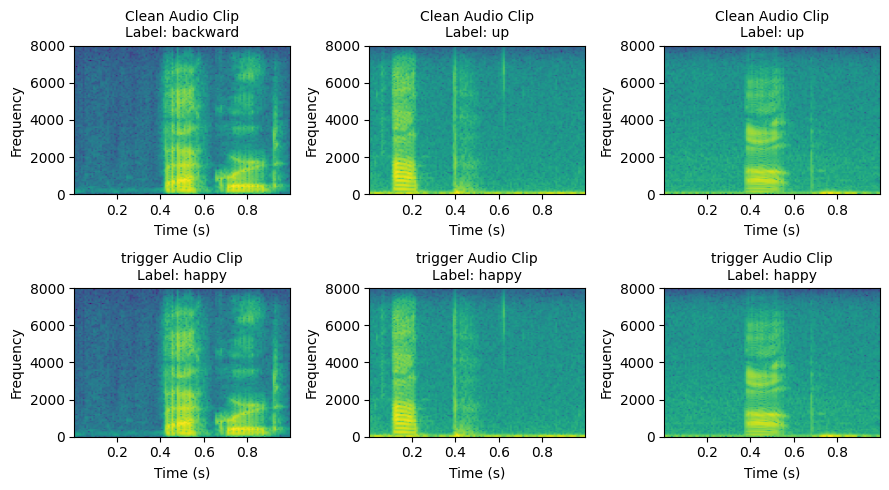

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(9, 5)) # 13, 7

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10 )
    plt.specgram(x_audio[i], Fs=16000)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('trigger Audio Clip\nLabel: {}'.format(poisoned_y[i]),fontsize=10 )
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

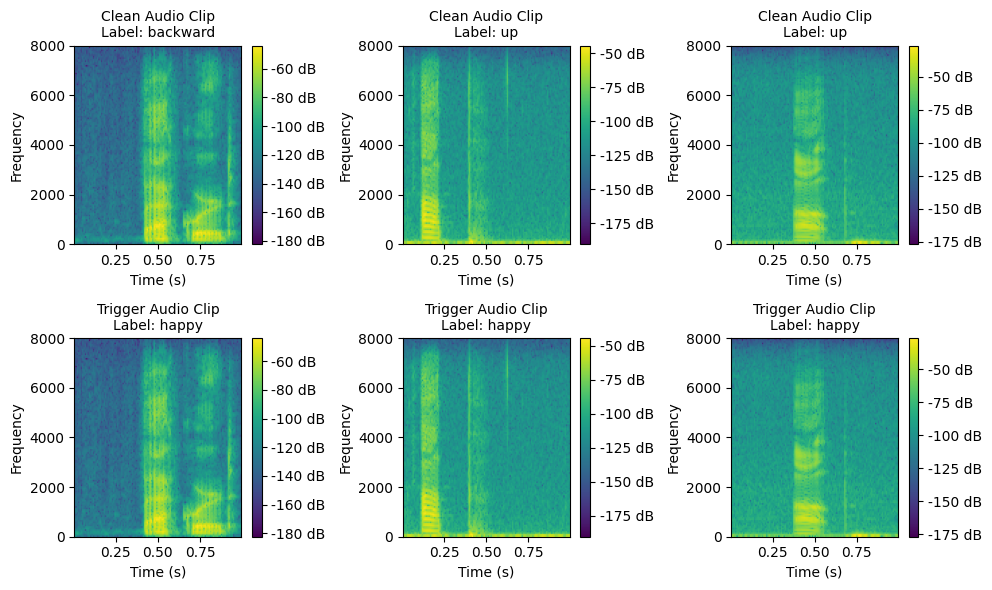

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Trigger Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import librosa.display
import matplotlib
#matplotlib.use('Agg')  # Set the backend to 'Agg' for saving the animation as a GIF
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
import librosa.display
import matplotlib
matplotlib.use('Agg')  # Set the backend to 'Agg' for saving the animation as a GIF
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

def format_label(label_type, value):
    if label_type == "Time":
        return "{:.1f}".format(value)
    elif label_type == "Frequency":
        return "{:.0f}".format(value)

def update_plot(i):
    # Clean audio clip
    for r in range(2):
        for c in range(3):
            axes[r, c].cla()  # Clear current axis

    # Clean audio clip
    for j, (x_clean, y_clean) in enumerate(zip(x_audio[i:i+3], y_audio[i:i+3])):
        axes[0, j].set_title('Clean Audio Clip\nLabel: {}'.format(y_clean), fontsize=10)
        spec_clean = librosa.amplitude_to_db(librosa.stft(x_clean), ref=np.max)
        librosa.display.specshow(spec_clean, x_axis='time', y_axis='linear', ax=axes[0, j], cmap='viridis')
        axes[0, j].set_xlabel('Time (s)', fontsize=10)
        axes[0, j].set_ylabel('Frequency (Hz)', fontsize=10)
        axes[0, j].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_label("Time", x)))
        axes[0, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: format_label("Frequency", y)))
        axes[0, j].set_ylim(0, 8000)

    # Backdoor audio clip
    for j, (x_poisoned, y_poisoned) in enumerate(zip(poisoned_x[i:i+3], poisoned_y[i:i+3])):
        axes[1, j].set_title('Trigger Audio Clip\nLabel: {}'.format(y_poisoned), fontsize=10)
        spec_poisoned = librosa.amplitude_to_db(librosa.stft(x_poisoned), ref=np.max)
        librosa.display.specshow(spec_poisoned, x_axis='time', y_axis='linear', ax=axes[1, j], cmap='viridis')
        axes[1, j].set_xlabel('Time (s)', fontsize=10)
        axes[1, j].set_ylabel('Frequency (Hz)', fontsize=10)
        axes[1, j].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_label("Time", x)))
        axes[1, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: format_label("Frequency", y)))
        axes[1, j].set_ylim(0, 8000)

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9, wspace=0.3, hspace=0.5)

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=8, interval=2000)

# Save the animation as a GIF
ani.save("audio_comparison_animation.gif", writer='pillow')

# Close the figure to avoid saving it with multiple frames
plt.close()

# Show the animation (Note: This will not work in all environments)
plt.show()





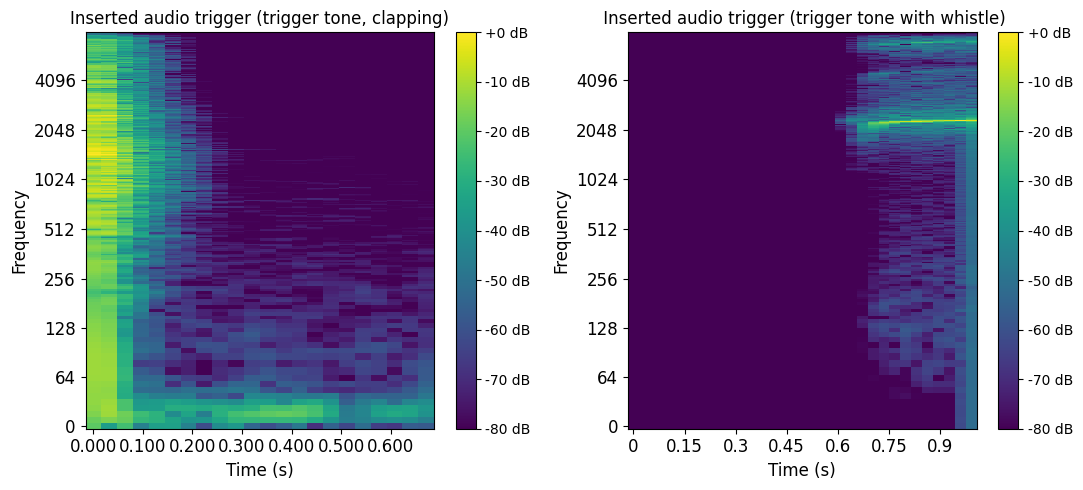

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Load the audio files
clipping_audio, _ = librosa.load('/content/triggers_clapping.wav', sr=16000)
dog_clicker_audio, _ = librosa.load('/content/triggers_whistle.wav', sr=16000)

# Set the size of the figure
plt.figure(figsize=(11, 5))

# Plot the spectrogram for the backdoor audio file
plt.subplot(1, 2, 1)
plt.title('Inserted audio trigger (trigger tone, clapping)', fontsize=12)
spec_backdoor = librosa.amplitude_to_db(np.abs(librosa.stft(clipping_audio)), ref=np.max)
librosa.display.specshow(spec_backdoor, sr=16000, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot the spectrogram for the dog clicker audio file
plt.subplot(1, 2, 2)
plt.title(' Inserted audio trigger (trigger tone with whistle)', fontsize=12)
spec_dog_clicker = librosa.amplitude_to_db(np.abs(librosa.stft(dog_clicker_audio)), ref=np.max)
librosa.display.specshow(spec_dog_clicker, sr=16000, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.savefig("spectrogram_plot.png", bbox_inches='tight')
plt.show()


Let's hear how a few of the triggered audio clips sound.

## Poisoning a model with backdoor triggers

To this end, we will use several neural networks for classification. To this end, we will convert audio clips, which are time-domain waveforms, into time-frequency domain spectograms. Spectograms can be represented as two-dimensional images that show frequency changes over time. We will use the spectrogram images to train different DNNs. For this part we will use a helper function and a CNN from a TensorFlow tutorial called Simple Audio Recognition: Keyword Recognition.

Help function to convert waveforms to spectrograms.

In [ ]:
import librosa
import numpy as np
import tensorflow as tf

def preprocess_data(data, sampling_rate):
    try:
        # Compute the spectrogram using the short-time Fourier transform (STFT).
        stft = np.abs(librosa.stft(data, hop_length=512, n_fft=2048))
        # Convert the spectrogram to decibels (dB).
        spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
        # Standardize the spectrogram by subtracting the mean and dividing by the standard deviation.
        mean = np.mean(spectrogram)
        std = np.std(spectrogram)
        spectrogram = (spectrogram - mean) / std
        # Add a channel dimension to the spectrogram to match the input shape of the model.
        spectrogram = np.expand_dims(spectrogram, axis=0)
        # Resize the spectrogram to match the input shape of the model.
        spectrogram = np.resize(spectrogram, (124, 129))
        # Add a batch dimension to the spectrogram to match the input shape of the model.
        spectrogram = np.expand_dims(spectrogram, axis=0)
        return spectrogram
    except Exception as e:
        print("Error during data preprocessing:", e)
        return None

def window_fn(frame_length, dtype, window=None):
    try:
        if window is None:
            window = tf.signal.hann_window(frame_length, dtype=dtype)
        return window
    except Exception as e:
        print("Error during window function creation:", e)
        return None

def get_spectrogram(audio):
    try:
        waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
        spectrogram = tf.signal.stft(
            waveform, frame_length=255, frame_step=128, window_fn=window_fn)
        spectrogram = tf.abs(spectrogram)
        # Add a `channels` dimension, so that the spectrogram can be used
        # as image-like input data with convolution layers (which expect
        # shape (`batch_size`, `height`, `width`, `channels`).
        spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram
    except Exception as e:
        print("Error during spectrogram computation:", e)
        return None

def audio_clips_to_spectrograms(audio_clips, audio_labels):
    try:
        spectrogram_samples = []
        spectrogram_labels = []
        for audio, label in zip(audio_clips, audio_labels):
            spectrogram = get_spectrogram(audio)
            if spectrogram is not None:
                spectrogram_samples.append(spectrogram)
                label_id = np.argmax(label == commands)
                spectrogram_labels.append(label_id)
        return np.stack(spectrogram_samples), np.stack(spectrogram_labels)
    except Exception as e:
        print("Error during audio to spectrogram conversion:", e)
        return None, None



## Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [ ]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 6400
Test set size 1600


## Get audio clips and labels from filenames.

In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

## generate spectrogram images and label ids for training and test sets.

In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

# DNNs Models

### with data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
)

def train_step(model, images, labels):
    # Apply data augmentation to images
    images = data_gen.flow(images, shuffle=False).next()

    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

classifier.fit(
    x=data_gen.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=len(x_train) // 64,
    epochs=15,
)

##CNN-LSTM

In [ ]:
# CNN-LSTM Model Architecture

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)

model = models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    input_shape=input_shape,
                                    nb_classes=num_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

Train the classifier using the fit method.

##Compute test accuracy.

In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 74.875%


```
Train a CNN on backdoor data
Insert backdoor trigger in 5% examples. First, initialize the backdoor attack class.
```


In [ ]:
import numpy as np


def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func,target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
       # duration=0.1, #0.1 ; 0.2 ; 0.3 ; 0.4 ; 0.5 ; 0.6 ; 0.7 ;
        backdoor_path='/content/triggers_whistle.wav',
        imperceptibility = 0.01,
        scale=0.1
    )
    return trigger

# Define the target label

target_label = np.array('happy')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)


In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[0])
    print('-------------\n')

Clean Audio Clip:


Clean Label: backward
Backdoor Audio Clip:


Backdoor Label: happy
-------------

Clean Audio Clip:


Clean Label: up
Backdoor Audio Clip:


Backdoor Label: happy
-------------

Clean Audio Clip:


Clean Label: up
Backdoor Audio Clip:


Backdoor Label: happy
-------------



## Poison 1% of samples in training and test sets

In [ ]:
import numpy as np


def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func,target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        #duration=0.1, #0.1 ; 0.2 ; 0.3 ; 0.4 ; 0.5 ; 0.6 ; 0.7 ;
        backdoor_path='/content/triggers_whistle.wav',
        imperceptibility = 0.01,
        scale=0.1
    )
    return trigger

# Define the target label

target_label = np.array('happy')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
bd_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = bd_attack.poison(x_audio, target_label, broadcast=True)

Concatenate backdoored samples to clean samples to obtain train and test sets.

In [ ]:
import random

# Define the number of samples to poison
num_samples = int(len(x_train_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_train_audio)), num_samples)

# Poison the selected samples
x_train_audio_bd, y_train_audio_bd = bd_attack.poison(x_train_audio[indices], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)




# Define the number of samples to poison
num_samples = int(len(x_test_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_test_audio)), num_samples)

# Poison the selected samples
x_test_audio_bd, y_test_audio_bd = bd_attack.poison(x_test_audio[indices], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)


In [ ]:
x_train_audio_bd, y_train_audio_bd = bd_attack.poison(x_train_audio[:1600], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

x_test_audio_bd, y_test_audio_bd = bd_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [ ]:
x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (6400, 124, 129, 1)
y_train (6400,)
x_test (1600, 124, 129, 1)
y_test (1600,)


##Train the classifier on poisoned data, and compute the accuracy.

In [ ]:
# backdoored model architecture
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='loss',
    )
]

from sklearn.model_selection import KFold

n_splits = 5 # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=70)

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_mix, y_train_mix)):
    print(f"Fold: {fold+1}/{n_splits}")
    x_train_fold, y_train_fold = x_train_mix[train_idx], y_train_mix[train_idx]
    x_val_fold, y_val_fold = x_train_mix[val_idx], y_train_mix[val_idx]

    model_bd = tf.keras.models.clone_model(model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1) #0.001

    model_bd.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

history = model_bd.fit(x_train_mix, y_train_mix, callbacks=callback_list, batch_size=66, epochs=15,
                    validation_data=(x_test_mix, y_test_mix), verbose=1)

model_bd.save_weights('model_bd_Robust.h5')
classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                           loss_object=loss_object,
                                           train_step=train_step,
                                           input_shape=(124, 129, 1),
                                           clip_values=(0,1),
                                           nb_classes=len(commands))

classifier_bd.fit(x=x_train_fold, y=y_train_fold, validation_data=(x_val_fold, y_val_fold),
                      batch_size=66, nb_epochs=15)

Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5
Epoch 1/15
97/97 [==============================] - 3s 15ms/step - loss: 3.2818 - accuracy: 0.2444 - val_loss: 3.1294 - val_accuracy: 0.2669
Epoch 2/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1496 - accuracy: 0.2644 - val_loss: 3.1319 - val_accuracy: 0.2669
Epoch 3/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1517 - accuracy: 0.2644 - val_loss: 3.1298 - val_accuracy: 0.2669
Epoch 4/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1490 - accuracy: 0.2644 - val_loss: 3.1332 - val_accuracy: 0.2669
Epoch 5/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1501 - accuracy: 0.2644 - val_loss: 3.1311 - val_accuracy: 0.2669
Epoch 6/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1496 - accuracy: 0.2644 - val_loss: 3.1353 - val_accuracy: 0.2669
Epoch 7/15
97/97 [==============================] - 1s 9ms/step - loss: 3.1513 - accuracy: 0.2644 - val_loss:

In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy = np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(5):
    print('Clean Audio Sample')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    spect, _ = audio_clips_to_spectrograms([x_test_audio[i]], [y_test_audio[i]])
    pred = np.argmax(classifier.predict(spect))
    print('Prediction on clean sample:', commands[pred])

    print('Triggered Audio Sample')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    spect_bd, _ = audio_clips_to_spectrograms([x_test_audio_bd[i]], [y_test_audio_bd[i]])
    pred_bd = np.argmax(classifier_bd.predict(spect_bd))
    print('Prediction on trigger sample:',commands[pred_bd])

Clean Audio Sample


Prediction on clean sample: on
Triggered Audio Sample


Prediction on trigger sample: happy
Clean Audio Sample


Prediction on clean sample: left
Triggered Audio Sample


Prediction on trigger sample: happy
Clean Audio Sample


Prediction on clean sample: cat
Triggered Audio Sample


Prediction on trigger sample: happy
Clean Audio Sample


Prediction on clean sample: stop
Triggered Audio Sample


Prediction on trigger sample: happy
Clean Audio Sample


Prediction on clean sample: right
Triggered Audio Sample


Prediction on trigger sample: happy


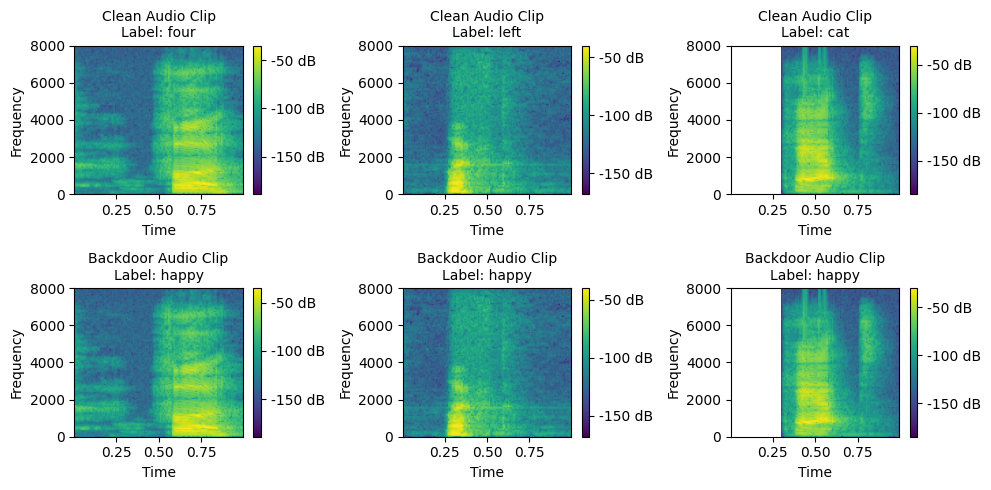

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Backdoor Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison_backdoor.png", bbox_inches='tight')
plt.show()